<a href="https://colab.research.google.com/github/vasilyryabtsev/ml-hse-24-25/blob/main/HW5_Boosting/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE, root_mean_squared_error as RMSE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import optuna
from optuna.integration import CatBoostPruningCallback
import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

In [5]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [6]:
experience_level_cat = ['SE', 'MI', 'EN', 'EX']
employment_type_cat = ['FT', 'PT', 'CT', 'FL']
company_size_cat = ['S', 'M', 'L']

cat_dict = {
    'experience_level': experience_level_cat,
    'employment_type': employment_type_cat,
    'company_size': company_size_cat
}

for cat in cat_dict:
    print(cat)
    print(df[df[cat].isin(cat_dict[cat])].shape[0] == df.shape[0])
    print('---------------')


experience_level
True
---------------
employment_type
True
---------------
company_size
True
---------------


`В выбранных признаках нет лишних значений.`

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [7]:
df.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


`Пропусков нет.`

In [8]:
df.duplicated().sum()

1171

`В датасете есть дубли, которые следует удалить.`

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2584 non-null   int64 
 1   experience_level    2584 non-null   object
 2   employment_type     2584 non-null   object
 3   job_title           2584 non-null   object
 4   salary              2584 non-null   int64 
 5   salary_currency     2584 non-null   object
 6   salary_in_usd       2584 non-null   int64 
 7   employee_residence  2584 non-null   object
 8   remote_ratio        2584 non-null   int64 
 9   company_location    2584 non-null   object
 10  company_size        2584 non-null   object
dtypes: int64(4), object(7)
memory usage: 242.2+ KB


`С типами данных всё нормально.`

In [11]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


`В salary есть выбросы.`

In [12]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,2584,2584,2584,2584,2584,2584,2584
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,1554,2547,598,2107,1893,1929,2028


`Нет признаков с одним значением.`

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

`Признак salary в совокупности с salary_currency полностью определяет таргет, поэтому salary необходимо удалить. salary_currency можно оставить, поскольку этот признак может нести дополнительную информацию о зарплатном масштабе в зависмости от региона (в одном регионе может выплачиваться зарплата в разных валютах, что может отразиться на размере зарплаты).`

In [13]:
df.drop('salary', axis=1, inplace=True)

`Большое кол-во категорий содержут признаки job_title, salary_currency, employee_residence, company_location.`

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [14]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [16]:
Xtrain.select_dtypes(include='number')

,work_year,remote_ratio
25,2023,0
2647,2022,0
2624,2022,0
2565,2022,100
2390,2022,0
...,...,...
2477,2022,100
1656,2023,0
1711,2023,0
1936,2022,0


In [17]:
Xtrain_num = Xtrain.select_dtypes(include='number')
Xtest_num = Xtest.select_dtypes(include='number')

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [18]:
def print_metrics(y_true, y_pred):
    """
    Печатает метрики MAPE, RMSE.
    """
    print(f'MAPE: {MAPE(y_true, y_pred):.3}')
    print(f'RMSE: {RMSE(y_true, y_pred)}')

In [19]:
lin_reg = LinearRegression()

lin_reg.fit(Xtrain_num, ytrain)

print_metrics(ytest, lin_reg.predict(Xtest_num))

MAPE: 0.829
RMSE: 64000.532625649634


`Качество модели получилось довольно плохим. В среднем прогноз модели отличается от истинного значения на 83 процента.`

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [20]:
cat_boost = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent'
)

cat_boost.fit(Xtrain_num, ytrain, plot=True)

print_metrics(ytest, cat_boost.predict(Xtest_num))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE: 0.771
RMSE: 62433.34798150249


`Ошибка стала меньше, но качество всё еще очень плохое.`

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [21]:
categorical = X.select_dtypes(include='object').columns

In [22]:
ct_ohe = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical)
], remainder='passthrough')

lgbm_ohe = Pipeline([
    ('column_transformer', ct_ohe),
    ('lgbm', LGBMRegressor(random_state=42))
])

lgbm_ohe.fit(Xtrain, ytrain)

print_metrics(ytest, lgbm_ohe.predict(Xtest))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 39
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.443
RMSE: 53015.82085407753


In [23]:
lin_reg_ohe = Pipeline([
    ('column_transformer', ct_ohe),
    ('model', LinearRegression())
])

lin_reg_ohe.fit(Xtrain, ytrain)

print_metrics(ytest, lin_reg_ohe.predict(Xtest))

MAPE: 0.467
RMSE: 53324.12270330814


`В LabelEncoder из sklearn нет параметров, которые позволяли бы работать с неизвестными значениями, поэтому придется обучать кодировщик и на трейне и на тесте.`

In [24]:
def label_encoder(df, columns):
    """
    Применяет LabelEncoder к столбцам columns датафрейма df.
    """
    df_cp = df.copy()
    for col in columns:
        le = LabelEncoder()
        le.fit(df_cp[col])
        df_cp[col] = le.transform(df_cp[col])
    return df_cp

lgbm_label = LGBMRegressor(random_state=42)

lgbm_label.fit(label_encoder(Xtrain, categorical), ytrain)

print_metrics(ytest, lgbm_label.predict(label_encoder(Xtest, categorical)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 8
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.692
RMSE: 96935.97293229477


In [25]:
lin_reg_label = LinearRegression()

lin_reg_label.fit(label_encoder(Xtrain, categorical), ytrain)

print_metrics(ytest, lin_reg_label.predict(label_encoder(Xtest, categorical)))

MAPE: 0.47
RMSE: 77097.0492963484


In [26]:
ct_te = ColumnTransformer([
    ('target_encoder', TargetEncoder(random_state=42), categorical)
], remainder='passthrough')

lgbm_te = Pipeline([
    ('column_transformer', ct_te),
    ('model', LGBMRegressor(random_state=42))
])

lgbm_te.fit(Xtrain, ytrain)

print_metrics(ytest, lgbm_te.predict(Xtest))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.376265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42359
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 6163
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.404
RMSE: 51849.126513271745


In [27]:
lin_reg_te = Pipeline([
    ('column_transformer', ct_te),
    ('model', LinearRegression())
])

lin_reg_te.fit(Xtrain, ytrain)

print_metrics(ytest, lin_reg_te.predict(Xtest))

MAPE: 4.11
RMSE: 1947706.8236224828


| model \ metric       | MAPE | RMSE    |
|----------------------|------|---------|
| Ohe + lgbm           | 0.44 | 53016   |
| Ohe + lin-reg        | 0.47 | 53324   |
| Label-enc + lgbm     | 0.69 | 96936   |
| Label-enc + lin-reg  | 0.47 | 77097   |
| Target-enc + lgbm    | 0.40 | 51849   |
| Target-enc + lin-reg | 4.11 | 1947706 |

`В двух из трех случаев линейная регрессия показала достаточно хороший результат в сравнении с LightGBM: при кодировке OneHotEncoder результат чуть хуже, а для LabelEncoder даже лучше, причем значительно. Это может говорить о том, что возможно таргет неплохо объясняется линейной моделью. В случае TargetEncoder линейная регрессия имеет огромную ошибку, это возможно связано с численными проблемами при вычислении моделью LinearRegression.`

`На данном примере хорошо видно, проблему ассимитричности метрики MAPE и её смещенность в сторону больших значений. Линейная регрессия обученная на кодировке OneHotEncoding и Label-encoding имееет одинаковое качество по метрике MAPE, при этом RMSE имеет сильное различие в значениях. При этом в случае обучения LightGBM на тех же кадировках сильное различие в значениях имееют обе метрики.`

`Наихудшие качество на обоих моделях показала кадировка Label-encoding. Это связано с тем, что при кодировании категорий по порядку категориальный признак становится ординальным, поэтому изначальные зависимости в данных могут исказиться при обучении модели. Также на это может влиять обучение водировщика на трейне и тесте в отдельности.`

`Наилучшее качество на всех метриках показала модель LightGBM, с кадировкой категориальных признаков методов TargetEncoder.`

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [28]:
model = lgbm_te

In [29]:
big_error_samples = df.loc[[e[1] for e in sorted(zip(abs(model.predict(Xtrain) - ytrain), Xtrain.index), reverse=True)[:20]]]
big_error_samples

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
528,2023,SE,FT,AI Scientist,ILS,423834,IL,0,IL,L
3747,2021,MI,FT,Applied Machine Learning Scientist,USD,423000,US,50,US,L
3522,2020,MI,FT,Research Scientist,USD,450000,US,0,US,M
3750,2020,SE,FT,Data Scientist,USD,412000,US,100,US,L
3463,2022,SE,FT,Data Analytics Lead,USD,405000,US,100,US,L
1105,2023,SE,FT,Data Scientist,USD,370000,US,0,US,M
649,2023,SE,FT,Data Architect,USD,376080,US,100,US,M
2374,2022,SE,FT,Data Scientist,USD,350000,US,100,US,M
2359,2022,SE,FT,Data Science Tech Lead,USD,375000,US,50,US,L
83,2022,EN,FT,AI Developer,USD,300000,IN,50,IN,L


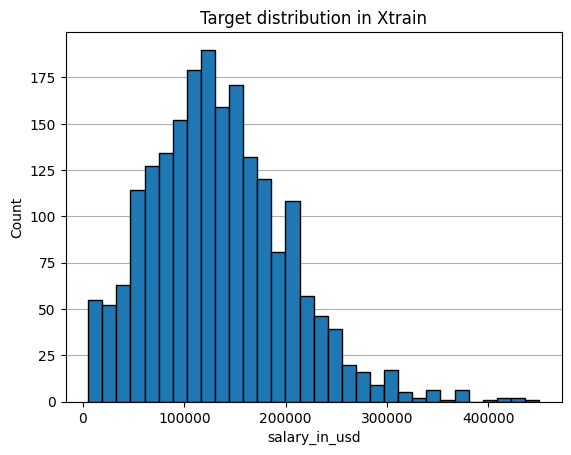

In [30]:
fig, ax = plt.subplots()

sns.histplot(ytrain, zorder=2, ax=ax, alpha=1)

plt.title('Target distribution in Xtrain')
plt.grid(True, axis='y', linestyle='-', zorder=1)

plt.show()

`Высокая ошибка, судя по всему, связана с аномальными значением зарплаты, преимущественно, для сеньеров (>300k $). Удалять такие данные не надо, поскольку такие зарплаты действительно могут существовать.`

In [31]:
Xtrain['experience_level'].value_counts()

,count
experience_level,
SE,1240
MI,536
EN,213
EX,78


`Интересно, что в датасете в принципе большинство позиций являются сеньерскими.`

`Средняя зарплата позиций с аномальными значениями зарплаты:`

In [32]:
df.loc[ytrain[ytrain > 300000].index].groupby('job_title')['salary_in_usd'].mean()

,salary_in_usd
job_title,
AI Scientist,423834.000000
Applied Data Scientist,380000.000000
Applied Machine Learning Scientist,423000.000000
Applied Scientist,329700.000000
Computer Vision Engineer,342810.000000
Data Analytics Lead,405000.000000
Data Architect,360840.000000
Data Engineer,313500.000000
Data Science Tech Lead,375000.000000


`Для улучшения модели можно добавить дополнительный признак-индикатор для высооплачиваемых вакансий.`

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

`Реализуем идею из предыдущего пункта.`

`Название вакансий с высокой зарплатой:`

In [33]:
high_salary_jobs = df.loc[ytrain[ytrain > 300000].index]['job_title'].unique()
high_salary_jobs

array(['Machine Learning Software Engineer', 'Applied Scientist',
       'Data Architect', 'Data Scientist', 'AI Scientist',
       'Data Engineer', 'Machine Learning Engineer', 'Head of Data',
       'Research Scientist', 'Applied Data Scientist',
       'Principal Data Scientist', 'Data Science Tech Lead',
       'Head of Data Science', 'Computer Vision Engineer',
       'Applied Machine Learning Scientist', 'Director of Data Science',
       'Data Analytics Lead'], dtype=object)

In [34]:
def high_salary_job(X):
    """
    Добавляет столбец high_salary_jobs, который равен 1, если job_title входит в список high_salary_jobs, иначе 0.
    """
    X_copy = X.copy()
    high_salary_jobs = ['Machine Learning Software Engineer', 'Applied Scientist',
       'Data Architect', 'Data Scientist', 'AI Scientist',
       'Data Engineer', 'Machine Learning Engineer', 'Head of Data',
       'Research Scientist', 'Applied Data Scientist',
       'Principal Data Scientist', 'Data Science Tech Lead',
       'Head of Data Science', 'Computer Vision Engineer',
       'Applied Machine Learning Scientist', 'Director of Data Science',
       'Data Analytics Lead']
    X_copy['high_salary_jobs'] = X_copy['job_title'].apply(lambda x: 1 if x in high_salary_jobs else 0)
    return X_copy

high_salary_transformer = FunctionTransformer(high_salary_job)

In [35]:
lgbm_nf_te = Pipeline([
    ('high_salary_transformer', high_salary_transformer),
    ('column_transformer', ct_te),
    ('model', LGBMRegressor(random_state=42))
])

lgbm_nf_te.fit(Xtrain, ytrain)

print_metrics(ytest, lgbm_nf_te.predict(Xtest))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42361
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 6164
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.388
RMSE: 51346.16983001252


`Качество немного улучшилось!`

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [40]:
Xtrain_new, Xval, ytrain_new, yval = train_test_split(high_salary_transformer.transform(Xtrain),
                                                      ytrain,
                                                      test_size=0.2,
                                                      random_state=42)

`Методика из документации catboost:` [ссылка](https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_pruning.py)

`Сначала подберем оптимальное количество итераций.`

In [59]:
model = CatBoostRegressor(
    cat_features=list(categorical),
    random_seed=42,
    iterations=2000,
    od_type='IncToDec',
    od_wait=50,
    use_best_model=True,
    eval_metric='RMSE',
    logging_level='Verbose'
)

model.fit(
    Xtrain_new, ytrain_new,
    eval_set=[(Xval, yval)],
)

Learning rate set to 0.036102
0:	learn: 67093.1526956	test: 65132.7658064	best: 65132.7658064 (0)	total: 3.36ms	remaining: 6.71s
1:	learn: 66357.0734243	test: 64389.2421459	best: 64389.2421459 (1)	total: 12.2ms	remaining: 12.2s
2:	learn: 65757.8097421	test: 63714.5343092	best: 63714.5343092 (2)	total: 14.4ms	remaining: 9.56s
3:	learn: 65108.3091531	test: 63043.7794657	best: 63043.7794657 (3)	total: 21.4ms	remaining: 10.7s
4:	learn: 64443.1876182	test: 62380.1732751	best: 62380.1732751 (4)	total: 26.1ms	remaining: 10.4s
5:	learn: 63843.7161447	test: 61762.3440263	best: 61762.3440263 (5)	total: 32.5ms	remaining: 10.8s
6:	learn: 63311.5894254	test: 61236.0948667	best: 61236.0948667 (6)	total: 36.1ms	remaining: 10.3s
7:	learn: 62749.9445931	test: 60748.5878215	best: 60748.5878215 (7)	total: 42.2ms	remaining: 10.5s
8:	learn: 62390.4227269	test: 60436.3074265	best: 60436.3074265 (8)	total: 43ms	remaining: 9.52s
9:	learn: 61937.2050967	test: 60006.4318105	best: 60006.4318105 (9)	total: 46.6ms

In [50]:
def objective(trial: optuna.Trial) -> float:
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "eval_metric": "RMSE",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostRegressor(**param,
                            cat_features=list(categorical),
                            random_seed=42,
                            iterations=309)

    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    gbm.fit(
        Xtrain_new,
        ytrain_new,
        eval_set=[(Xval, yval)],
        early_stopping_rounds=100,
        verbose=0,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(Xval)
    rmse = RMSE(yval, preds)

    return -rmse

study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective, n_trials=1000, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(-trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-15 08:57:02,238] A new study created in memory with name: no-name-65135c3b-6221-46c8-8dc3-9ccc0183203d
[I 2025-02-15 08:57:02,486] Trial 0 finished with value: -50561.96279748752 and parameters: {'colsample_bylevel': 0.018978033557435714, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35725667334773353}. Best is trial 0 with value: -50561.96279748752.
[I 2025-02-15 08:57:02,862] Trial 1 finished with value: -48857.07615717131 and parameters: {'colsample_bylevel': 0.05959217030290399, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7014832136279918}. Best is trial 1 with value: -48857.07615717131.
[I 2025-02-15 08:57:03,177] Trial 2 finished with value: -50874.96908062832 and parameters: {'colsample_bylevel': 0.020634762689669225, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: -48857.07615717131.
[I 2025-02-15 08:57:03,453] Trial 3 finished with value: -

Number of finished trials: 427
Best trial:
  Value: 47739.150534849214
  Params: 
    colsample_bylevel: 0.09518264556511419
    depth: 10
    boosting_type: Ordered
    bootstrap_type: MVS


In [60]:
model = CatBoostRegressor(
    iterations=309,
    cat_features=list(categorical),
    random_seed=42,
    **trial.params,
    logging_level='Silent'
)
pipeline = Pipeline([
        ('high_salary_transformer', high_salary_transformer),
        ('model', model)
])

In [61]:
%%time
pipeline.fit(Xtrain, ytrain)

CPU times: user 2.97 s, sys: 189 ms, total: 3.16 s
Wall time: 4.27 s


Pipeline(steps=[('high_salary_transformer',
                 FunctionTransformer(func=<function high_salary_job at 0x7ed14f9c8220>)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7ed12fb46d50>)])

In [62]:
%%time
preds = pipeline.predict(Xtest)

CPU times: user 11.4 ms, sys: 32 µs, total: 11.4 ms
Wall time: 27.7 ms


In [64]:
print_metrics(ytest, preds)

MAPE: 0.425
RMSE: 50641.90602142295


`Качество модели по метрике RMSE немного улучшилось, по MAPE немного ухудшилось. Обучается и предсказывает модель очень быстро.`

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
def objective(trial):

    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1.0)
    }

    model = xgb.XGBRegressor(random_state=42, **param)

    pipeline = Pipeline([
        ('high_salary_transformer', high_salary_transformer),
        ('column_transformer', ct_te),
        ('model', model)
    ])

    scores = cross_val_score(pipeline, Xtrain, ytrain, cv=3,
                             scoring='neg_root_mean_squared_error', n_jobs=-1)

    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Лучшие параметры:", study.best_params)
print("Лучший RMSE:", study.best_value)

[I 2025-02-14 18:54:42,972] A new study created in memory with name: no-name-fe6adff9-1da8-4608-bd2c-51c8fa0cae06
[I 2025-02-14 18:55:48,789] Trial 0 finished with value: 55924.89453125 and parameters: {'max_depth': 5, 'learning_rate': 0.0014629527913604522, 'n_estimators': 450, 'subsample': 0.9951557675857973, 'colsample_bytree': 0.7219991356987236, 'gamma': 0.0003694099915561159, 'reg_alpha': 0.0039345361852979824, 'reg_lambda': 0.000797287969081049}. Best is trial 0 with value: 55924.89453125.
[I 2025-02-14 18:56:12,605] Trial 1 finished with value: 50753.203125 and parameters: {'max_depth': 4, 'learning_rate': 0.059616259791276105, 'n_estimators': 287, 'subsample': 0.8528704621951508, 'colsample_bytree': 0.833603531857853, 'gamma': 0.6691732232969455, 'reg_alpha': 0.0033332069863012933, 'reg_lambda': 0.004808041186238401}. Best is trial 1 with value: 50753.203125.
[I 2025-02-14 18:56:33,145] Trial 2 finished with value: 51467.490885416664 and parameters: {'max_depth': 8, 'learning_

KeyboardInterrupt: 

In [52]:
model = xgb.XGBRegressor(random_state=42, **study.best_params)

pipeline = Pipeline([
        ('high_salary_transformer', high_salary_transformer),
        ('column_transformer', ct_te),
        ('model', model)
])

pipeline.fit(Xtrain, ytrain)

print_metrics(ytest, pipeline.predict(Xtrain))

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:experience_level: object, employment_type: object, job_title: object, salary_currency: object, employee_residence: object, company_location: object, company_size: object

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 127),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1.0),
    }

    model = LGBMRegressor(random_state=42, **param)

    pipeline = Pipeline([
        ('high_salary_transformer', high_salary_transformer),
        ('column_transformer', ct_te),
        ('model', model)
    ])

    scores = cross_val_score(pipeline, Xtrain, ytrain, cv=3,
                             scoring='neg_root_mean_squared_error', n_jobs=-1)

    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Лучшие параметры:", study.best_params)
print("Лучший RMSE:", study.best_value)

[I 2025-02-14 18:45:29,203] A new study created in memory with name: no-name-546b7f80-063a-4c50-9f04-a49e0ceeb830
<ipython-input-55-48551833bfed>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),  # маленький learning_rate для лучшего обучения
<ipython-input-55-48551833bfed>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),  # агрегация через случайный подбор
<ipython-input-55-48551833bfed>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

KeyboardInterrupt: 

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

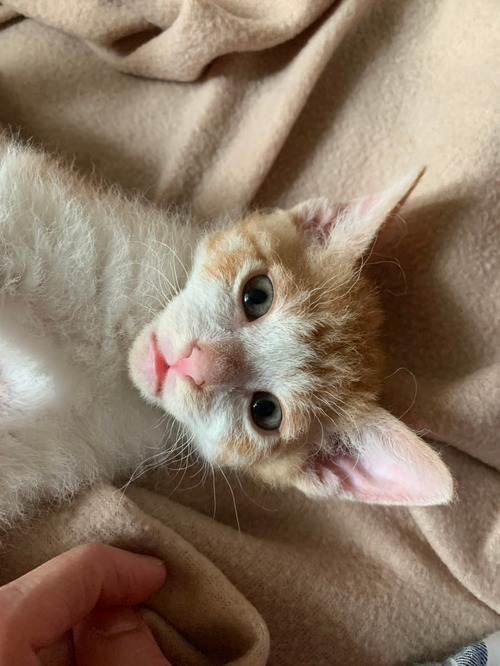